# 3.0 Build models

AIMS

In this document, the following models are implemented:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from mypackage import dir
from mypackage.rfm import cut_rfm

modality =  modality = 'p'
project = 'australian'
data = dir.make_dir_line(modality, project) 
processed = data('processed')
models = data('models')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

## 3.1 Load data

In [3]:
dataset = pd.read_parquet(processed/'dataset.parquet.gzip')

## 3.2 Escale data

In [4]:
df_esc = dataset.copy()
df_esc = df_esc.loc[:,['id_cliente', 'sexo', 'age_days', 'recency', 'monetary',
                       'Babucha', 'Bermuda', 'Calza', 'Camisa', 'Capri', 'Chaleco', 'Jean',
                       'Mini', 'Pantalón', 'Pollera', 'Remera', 'Short',
                       'Strapless', 'Vestido', 'local']]

# Escalar las características
scaler = MinMaxScaler()
scaler2 = StandardScaler()
data_scaled = scaler.fit_transform(df_esc.loc[:, df_esc.columns != 'id_cliente'])
data_scaled = scaler2.fit_transform(data_scaled)

## 3.3 RFM groups

In [5]:
df_models = dataset.copy()
df_models = df_models.loc[:,['id_cliente', 'recency', 'frequency', 'monetary']]
df_models = cut_rfm(df_models)
df_models['group_rfm'].value_counts()

group_rfm
About to Sleep              93
New Customers               91
Hibernating                 79
High Potential              62
Champions                   59
Need Attention              51
At Risk                     19
Low Potential               18
Uniquely Promising Highs    17
High New Customers          11
Name: count, dtype: int64

## 3.4 kmeans

In [6]:
cluster_range = range(2, 12)
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_scaled)
    
    # Append inertia (codo) and silhouette score to the lists
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

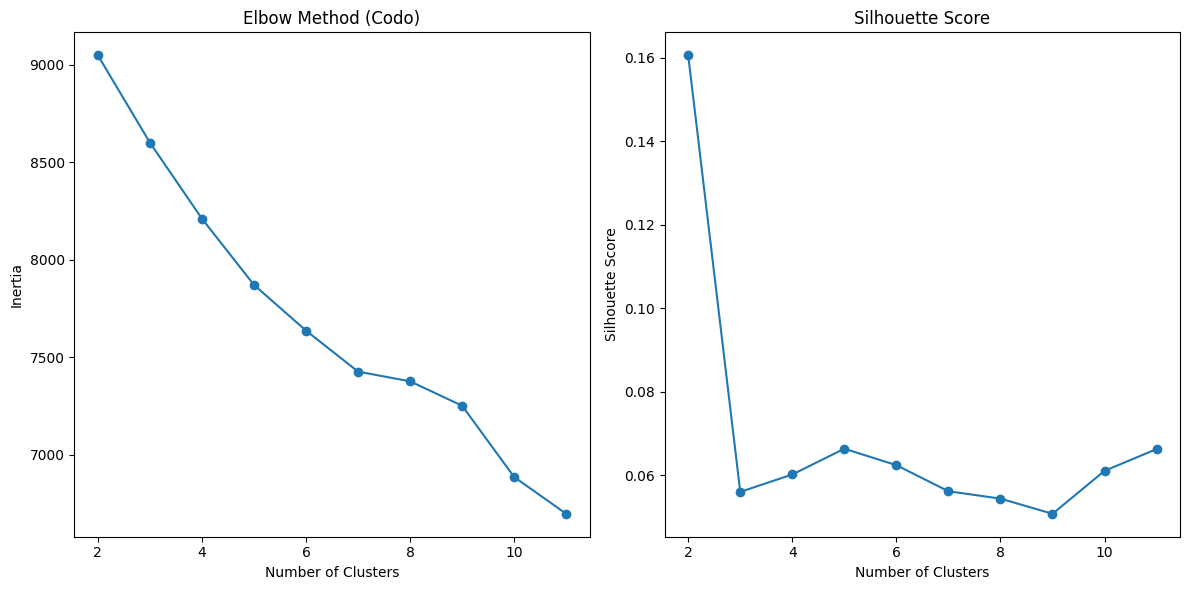

In [7]:
# Plot the elbow method (codo)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method (Codo)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [8]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data_scaled)
# predict kmeans
df_models['group_kmeans'] = kmeans.predict(data_scaled)
df_models['group_kmeans'].value_counts()

group_kmeans
2    176
1    171
4     78
3     45
0     30
Name: count, dtype: int64

## 3.5 GMM

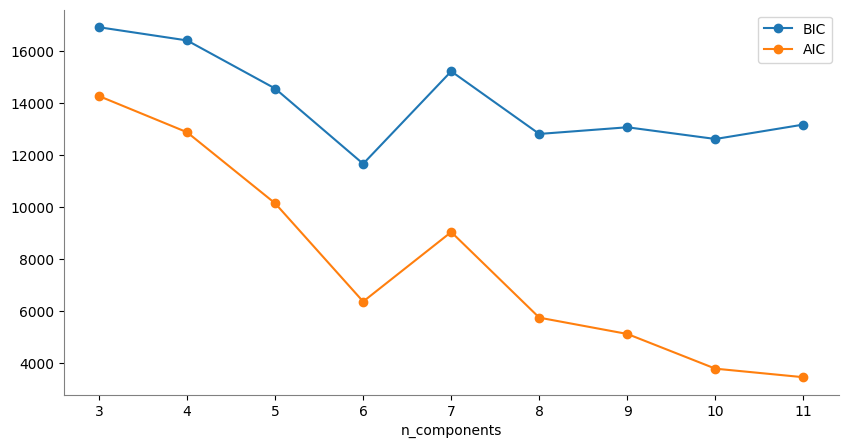

In [19]:
n_components = np.arange(3, 12)

gaussianModels = [
    GaussianMixture(n, covariance_type="full", random_state=42).fit(data_scaled)
    for n in n_components
]

plt.figure(figsize=(10, 5))
plt.plot(n_components, [model.bic(data_scaled) for model in gaussianModels], "o-", label="BIC")
plt.plot(n_components, [model.aic(data_scaled) for model in gaussianModels], "o-", label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [22]:
n_components = 4
gaussianMixture = GaussianMixture(
    n_components=n_components,
    covariance_type="full",
    max_iter=100,
    init_params="kmeans", #ramdom
    random_state=42,
)
gaussianMixture.fit(data_scaled)
# predict Gmm
df_models["group_gmm"] = gaussianMixture.predict(data_scaled)
df_models['group_gmm'].value_counts()

group_gmm
1    317
3    137
0     33
2     13
Name: count, dtype: int64

## Save models

In [24]:
df_models = df_models.loc[:,['id_cliente', 'group_rfm', 'segment_rfm', 'group_kmeans', 'group_gmm']]
df_models.shape

(500, 5)

In [26]:
# Save data
df_models.to_parquet(models/'df_models.parquet.gzip', compression='gzip')

In [14]:
print('ok_')

ok_
